# Multi-armed bandits: A gentle introduction to reinforcement learning

Michael Bloem

Mosaic Data Science

7 March 2019

mbloem@mosaicdatascience.com

This notebook demonstrates a couple of reinforcement learning policies for the multi-armed bandit problem. It is intended to be used as part of a presentation on this topic.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
from bandits import Bandits, RandomStrategy, epsilonGreedyStrategy, BayesianStrategy

In [4]:
from pymc import rbeta
from scipy.stats.distributions import beta

In [5]:
import numpy as np

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Demo of Beta distribution

First, let's take a look at the uniform prior for the Beta distribution.

(0, 1.0550000000000002)

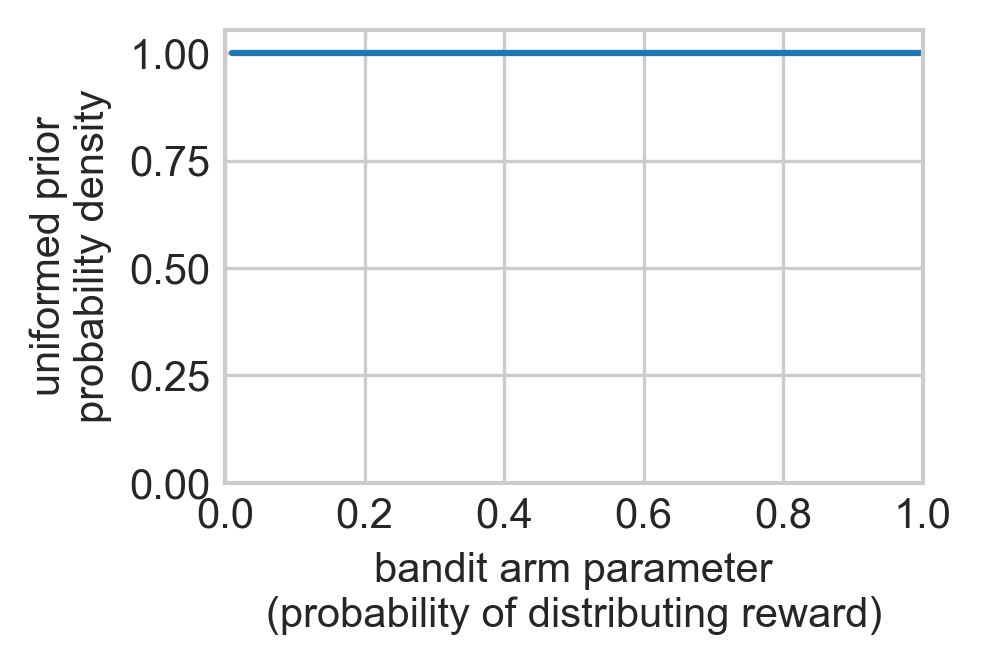

In [19]:
fig, ax = plt.subplots(figsize=(3,2))

xpoints = np.linspace(0.01,1.0,100)
ax.plot(
    xpoints,
    beta.pdf(x=xpoints,a=1,b=1),
)
ax.set_xlabel('bandit arm parameter\n(probability of distributing reward)')
ax.set_ylabel('uniformed prior\nprobability density')
ax.set_xlim([0,1])
ylim = ax.get_ylim()
ax.set_ylim([0,ylim[1]])

Now simulate some results from a bandit. We'll say this bandit has a success probability of 0.6.

In [8]:
bandit_arm_param = 0.6

num_successes = 0
num_failures = 0

(0, 3.5312236410175428)

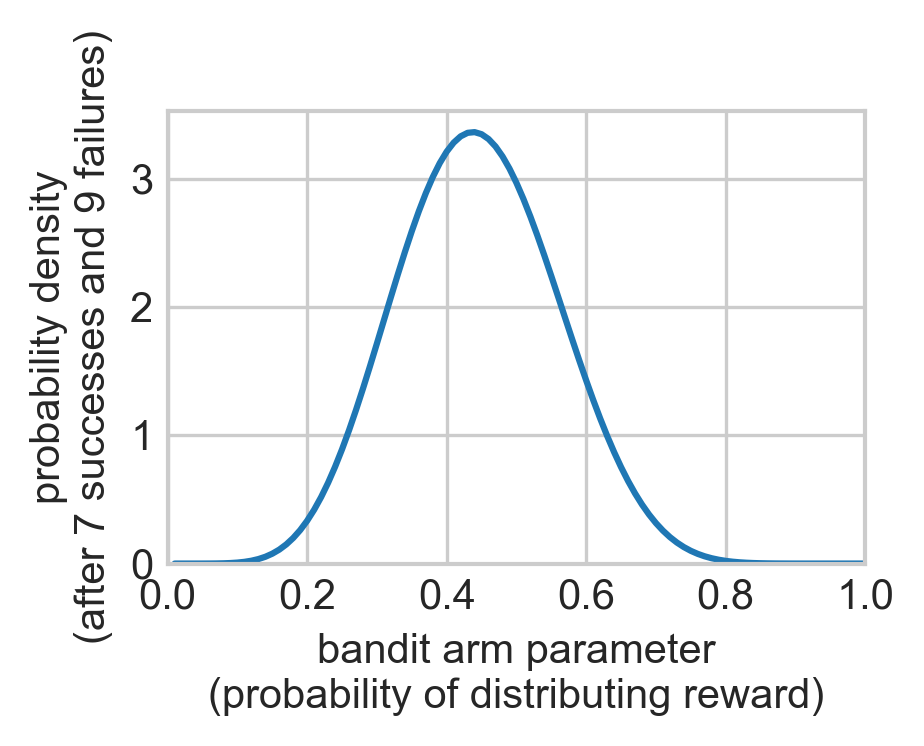

In [33]:
success = np.random.binomial(1,bandit_arm_param)

if success:
    num_successes += 1
else:
    num_failures += 1
    
fig, ax = plt.subplots(figsize=(3,2))

xpoints = np.linspace(0.01,1.0,100)
ax.plot(
    xpoints,
    beta.pdf(x=xpoints,a=1+num_successes,b=1+num_failures),
)
ax.set_xlabel('bandit arm parameter\n(probability of distributing reward)')
ax.set_ylabel('probability density\n(after {} successes and {} failures)'.format(num_successes, num_failures))
ax.set_xlim([0,1])
ylim = ax.get_ylim()
ax.set_ylim([0,ylim[1]])

## Compare performance of policies by running some experiments

### Set up experiment parameters

In [10]:
NUM_EXPERIMENTS = 50
NUM_PULLS = 10000
BANDITS_PROBS = [0.4, 0.5, 0.5, 0.5, 0.5, 0.6]

In [11]:
EPS_1 = 0.1
EPS_2 = 0.05

### Build some bandits

In [12]:
bandits = Bandits(BANDITS_PROBS)

In [13]:
len(bandits)

6

In [14]:
bandits.p

[0.4, 0.5, 0.5, 0.5, 0.5, 0.6]

### Run the experiment

In [15]:
# I'll keep a cumulative sum in these, then divide by the number of experiments at the end
random_total_regret = np.zeros(NUM_PULLS)
eps1_greedy_total_regret = np.zeros(NUM_PULLS)
eps2_greedy_total_regret = np.zeros(NUM_PULLS)
bayes_total_regret = np.zeros(NUM_PULLS)

random_total_reward = np.zeros(NUM_PULLS)
eps1_greedy_total_reward = np.zeros(NUM_PULLS)
eps2_greedy_total_reward = np.zeros(NUM_PULLS)
bayes_total_reward = np.zeros(NUM_PULLS)

for experiment in range(NUM_EXPERIMENTS):
    random_policy = RandomStrategy(bandits)
    random_policy.sample(NUM_PULLS)
    random_total_regret += np.cumsum(random_policy.regret)
    random_total_reward += np.cumsum(random_policy.score)
    
    eps1_greedy_policy = epsilonGreedyStrategy(bandits, EPS_1)
    eps1_greedy_policy.sample(NUM_PULLS)
    eps1_greedy_total_regret += np.cumsum(eps1_greedy_policy.regret)
    eps1_greedy_total_reward += np.cumsum(eps1_greedy_policy.score)
    
    eps2_greedy_policy = epsilonGreedyStrategy(bandits, EPS_2)
    eps2_greedy_policy.sample(NUM_PULLS)
    eps2_greedy_total_regret += np.cumsum(eps2_greedy_policy.regret)
    eps2_greedy_total_reward += np.cumsum(eps2_greedy_policy.score)
    
    bayes_policy = BayesianStrategy(bandits)
    bayes_policy.sample(NUM_PULLS)
    bayes_total_regret += np.cumsum(bayes_policy.regret)
    bayes_total_reward += np.cumsum(bayes_policy.score)
    
random_total_regret = random_total_regret/NUM_EXPERIMENTS
eps1_greedy_total_regret = eps1_greedy_total_regret/NUM_EXPERIMENTS
eps2_greedy_total_regret = eps2_greedy_total_regret/NUM_EXPERIMENTS
bayes_total_regret = bayes_total_regret/NUM_EXPERIMENTS

random_total_reward = random_total_reward/NUM_EXPERIMENTS
eps1_greedy_total_reward = eps1_greedy_total_reward/NUM_EXPERIMENTS
eps2_greedy_total_reward = eps2_greedy_total_reward/NUM_EXPERIMENTS
bayes_total_reward = bayes_total_reward/NUM_EXPERIMENTS

### Review the results

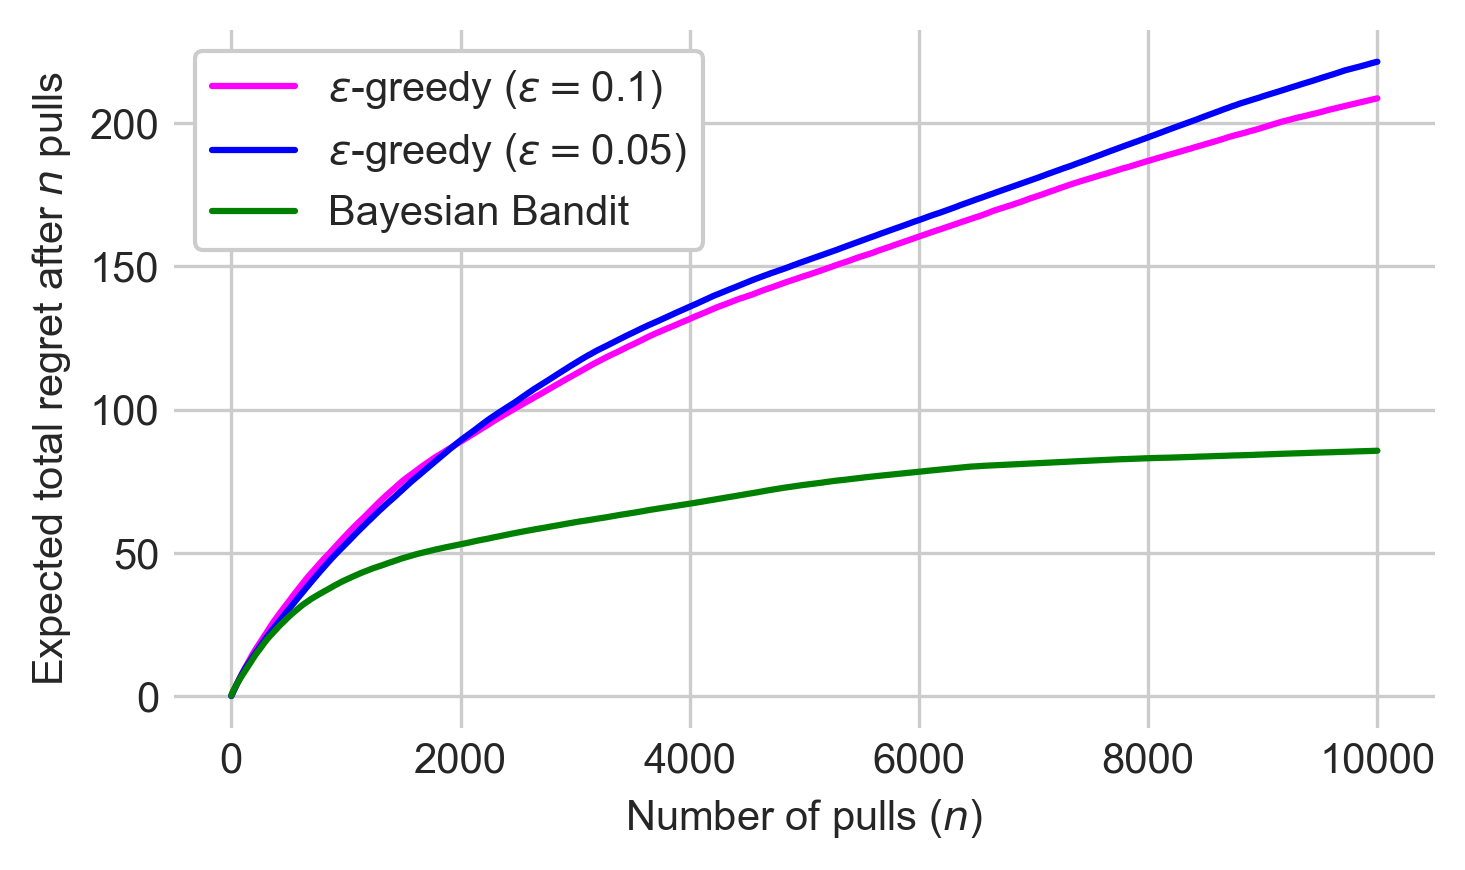

In [16]:
fig, ax = plt.subplots(figsize=(5,3))

# ax.plot(random_total_regret,
#               color='gray',
#               label='random',
#              )

ax.plot(eps1_greedy_total_regret,
              color='magenta',
              label='$\epsilon$-greedy ($\epsilon=${})'.format(EPS_1),
             )

ax.plot(eps2_greedy_total_regret,
              color='blue',
              label='$\epsilon$-greedy ($\epsilon=${})'.format(EPS_2),
             )

ax.plot(bayes_total_regret,
              color='green',
              label='Bayesian Bandit',
             )

for direction in ['left',"right", "top", 'bottom']:
    # hides borders
    ax.spines[direction].set_visible(False)

plt.ylabel('Expected total regret after $n$ pulls')
plt.xlabel('Number of pulls ($n$)')

plt.legend(loc='best', framealpha=1, frameon=True)

plt.tight_layout()

fig.savefig(os.path.join('output','plots','expected_total_regret.png'))

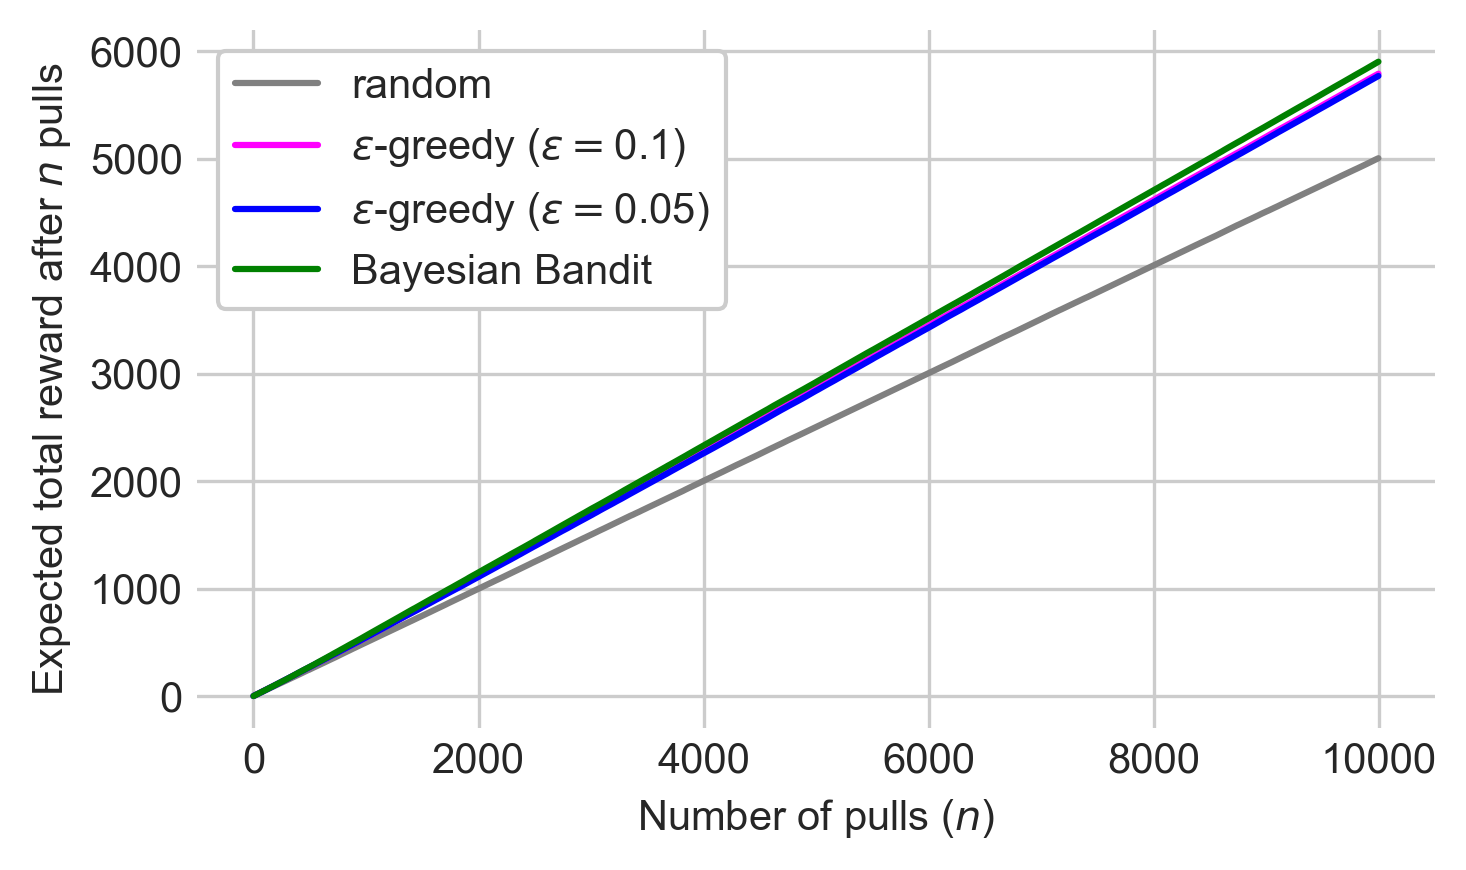

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

ax.plot(random_total_reward,
              color='gray',
              label='random',
             )

ax.plot(eps1_greedy_total_reward,
              color='magenta',
              label='$\epsilon$-greedy ($\epsilon=${})'.format(EPS_1),
             )

ax.plot(eps2_greedy_total_reward,
              color='blue',
              label='$\epsilon$-greedy ($\epsilon=${})'.format(EPS_2),
             )

ax.plot(bayes_total_reward,
              color='green',
              label='Bayesian Bandit',
             )

for direction in ['left',"right", "top", 'bottom']:
    # hides borders
    ax.spines[direction].set_visible(False)

plt.ylabel('Expected total reward after $n$ pulls')
plt.xlabel('Number of pulls ($n$)')

plt.legend(loc='best', framealpha=1, frameon=True)

plt.tight_layout()

fig.savefig(os.path.join('output','plots','expected_total_rewards.png'))